In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
CHANNELS = 3

In [10]:
def createGenerator(width, height, feature, depth):
    # 생성자 
    generator = keras.Sequential()
    # Dense 부터 생성한다.( input_dim은 랜덤하게 적당히 넣어준다. 딱히 값이 커도 성능이 좋아지진 않는다.)
    # 7 * 7 로 한 이유는 나중에 upsampling으로 2배를 곱하고, 다시 upsamepling을 해서 2배, 즉 4 * 7 = 28로 늘리기 때문이다.
    # 한 번에 늘리지 않고, 조금씩 늘리는 것이 DCGAN의 특징이다.
    generator.add(keras.layers.Dense(int(width/4)*int(height/4)*feature*depth, input_dim = 100,
                                    activation = keras.layers.LeakyReLU(alpha = 0.2)))
    # 전체 데이터를 평균 분산으로 만들어준다. Z trainsform이라고도 한다.
    # 일반적으로는 BatchNormalization을 먼저 끝내고 Dense로 받는 것도 있다. 순서에 대해서는 확인이 필요.
    generator.add(keras.layers.BatchNormalization())

    # 1차원(y)의 배열을 3차원(x, y, z)의 배열로 변경해준다.   
    generator.add(keras.layers.Reshape((int(width/4), int(height/4), feature*depth)))

    # 이미지를 가로 2배, 세로 2배로 늘린다. 
    generator.add(keras.layers.UpSampling2D())
    # CNN 
    generator.add(keras.layers.Conv2D(64, kernel_size = 5, padding = 'same'))

    # 다시 평균분산으로 만든다.
    generator.add(keras.layers.BatchNormalization())

    # 활성화 함수 LeakyReLU를 실행하기 위해서 Layer 추가
    generator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))

    # 2배 늘리기
    generator.add(keras.layers.UpSampling2D())

    # 가장 마지막에 tamh를 사용한다.
    # fake image 1장이 나와야 하기 때문에 1개의 output 설정
    generator.add(keras.layers.Conv2D(depth, kernel_size = 5, 
                                    padding = 'same', activation='tanh'))
    generator.summary()

    return generator

In [11]:
def createDiscrinator(width, height, depth):
    # 판별자
    input_shape= (width, height, depth)
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size = 5, strides = 2,
                                        input_shape= input_shape, padding = 'same'))
    model.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))

    model.add(keras.layers.Conv2D(128, kernel_size = 5, strides = 2,
                                        input_shape= input_shape, padding = 'same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
                        metrics = 'accuracy')
    model.trainable = False
    model.summary()

    return model

In [12]:
generator = createGenerator(100, 100, 128, CHANNELS)
discriminator = createDiscrinator(100, 100, CHANNELS)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 240000)            24240000  
                                                                 
 batch_normalization_4 (Batc  (None, 240000)           960000    
 hNormalization)                                                 
                                                                 
 reshape_2 (Reshape)         (None, 25, 25, 384)       0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 50, 50, 384)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)        614464    
                                                                 
 batch_normalization_5 (Batc  (None, 50, 50, 64)      

In [13]:
#목적 : gan의 생성자와 판별자를 연결한다.
ginput = keras.layers.Input(shape = (100, ) )
dis_output = discriminator(generator(ginput))


In [14]:

# gan 모델에 생성자, 판별자를 넣는다.
gan = keras.models.Model(ginput, dis_output)

gan.compile(loss = 'binary_crossentropy', optimizer = 'adam',
           metrics = 'accuracy') # print에 이슈가 있다면 metrics = accuracy 부분은 제거해준다.

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 100, 100, 3)       25819523  
                                                                 
 sequential_5 (Sequential)   (None, 1)                 289793    
                                                                 
Total params: 26,109,316
Trainable params: 25,339,395
Non-trainable params: 769,921
_________________________________________________________________


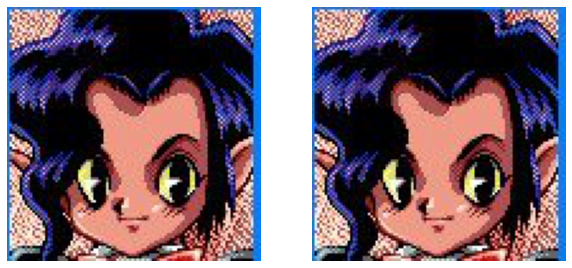

In [15]:
import glob
from matplotlib.pyplot import imread

# 이미지가 정상적으로 불러오는지 확인1
# keras.preprocessing.image.ImageDataGenerator 와 비교하면 어떤게 더 좋은가?
foldername = "src_images"

# load in the images as a numpy array of shape (number images x width x height x channels)
x_train_img = np.array([imread(im) for im in glob.glob(f"{foldername}/*.jpg")])
x_train = x_train_img.reshape(-1, 100, 100, 3).astype(np.float32)
img_cnt = int(len(x_train_img))
fig, axs = plt.subplots(1, 2, figsize = (10,10))

for i in range(img_cnt):
    axs[i].imshow(x_train_img[i])
    axs[i].axis('off')
plt.show()

Found 2 files belonging to 1 classes.


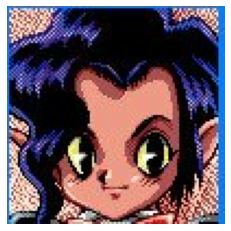

In [16]:
# 이미지가 정상적으로 불러오는지 확인2
src_data_dir = "src_images"
x_train_img = keras.utils.image_dataset_from_directory(src_data_dir, 
                                                        label_mode=None,
                                                        image_size=(100, 100), 
                                                        batch_size=32)
image_batch = next(iter(x_train_img))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [32]:
def gan_train(epoch, batch_size, saving_interval):
    depth = CHANNELS
    src_data_dir = "src_images"
    x_train_img = keras.utils.image_dataset_from_directory(src_data_dir, 
                                                            label_mode=None,
                                                            image_size=(100, 100), 
                                                            batch_size=32)
    # x_train = x_train_img.reshape(-1, 100, 100, 3).astype(np.float32)
    # x_train = (x_train - 127.5)/127.5
    train_images = x_train_img.map(lambda x: (x - 127.5) / 127.5)

    true = np.ones((batch_size, 1))
    # fake 이미지가 잘 안 만들어지면 이부분이 ones로 되어서 그런 것 같다.
    fake = np.zeros((batch_size, 1))

    d_losses = []
    g_losses = []

    for i in range(epoch):
        # real training loss
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # generator loss
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차 계산
        d_loss = np.add(d_loss_real, d_loss_fake)/2
        g_loss = gan.train_on_batch(noise, true)

        d_losses.append(d_loss)
        g_losses.append(g_loss)

        print('epoch: ', i, ' d_loss: ', d_loss, ' g_loss:', g_loss)


        # 그 때 만든 이미지를 gan images 폴더에 저장하라는 뜻,

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_images = generator.predict(noise)
            
            #Rescale images 0 ~ 1
            gen_imgs = gen_images*0.5 - 0.5

            fig, axe = plt.subplots(5, 5)

            count = 0
            for j in range(5):
                for k in range(5):
                    axe[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
                    axe[j, k].axis('off')

                    count += 1
            fig.savefig('gan_images/gan_mnist_%d.png' % i)
    return d_losses, g_losses

In [ ]:
d_loss, g_loss = gan_train(4001, 32, 10)

Found 2 files belonging to 1 classes.
epoch:  0  d_loss:  [6.15288013 0.        ]  g_loss: [0.018664605915546417, 1.0]
epoch:  1  d_loss:  [0.18045782 1.        ]  g_loss: [0.028214246034622192, 0.96875]
epoch:  2  d_loss:  [0.22562262 0.953125  ]  g_loss: [0.15006572008132935, 0.9375]
epoch:  3  d_loss:  [1.65991354 0.5       ]  g_loss: [8.158439595717937e-05, 1.0]
epoch:  4  d_loss:  [4.24173641 0.5       ]  g_loss: [0.2595047354698181, 0.875]
epoch:  5  d_loss:  [0.6688754 0.59375  ]  g_loss: [4.508462905883789, 0.3125]
epoch:  6  d_loss:  [1.06563448e-06 1.00000000e+00]  g_loss: [13.563690185546875, 0.21875]
epoch:  7  d_loss:  [8.49525117e-10 1.00000000e+00]  g_loss: [20.944400787353516, 0.4375]
epoch:  8  d_loss:  [8.34800684e+02 5.00000000e-01]  g_loss: [4.209352493286133, 0.59375]
epoch:  9  d_loss:  [20.8508625  0.5      ]  g_loss: [6.326909065246582, 0.65625]
epoch:  10  d_loss:  [30.59321785  0.5       ]  g_loss: [0.8997461199760437, 0.9375]
epoch:  11  d_loss:  [27.88369179